## Sales forecasting using XGBoost model

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

C:\Users\sonal\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read the data
df=pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [4]:
#converting date column to datetime datatype
df['date']=pd.to_datetime(df['date'])

In [5]:
# Choosing 6 items to perform the sales forecasting
dff = df[df['item'].isin([1,2,3,5,8,9])]
dff.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
# Finding total sales across all stores
dff=dff.groupby(["item", "date"]).agg(sales=('sales','sum')).reset_index()
dff.head()

,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149


In [7]:
kt=dff.copy()

In [8]:
#Create new columns based on date column
kt['month'] = kt['date'].apply(lambda x:x.month)
kt['day_of_month'] = kt['date'].apply(lambda x:x.day)
kt['year'] = kt['date'].apply(lambda x:x.year)
kt['day_of_week'] = kt['date'].apply(lambda x:x.weekday())
kt['quarter'] = kt['date'].apply(lambda x:x.quarter)

In [9]:
kt.head()

,item,date,sales,month,day_of_month,year,day_of_week,quarter
0,1,2013-01-01,133,1,1,2013,1,1
1,1,2013-01-02,99,1,2,2013,2,1
2,1,2013-01-03,127,1,3,2013,3,1
3,1,2013-01-04,145,1,4,2013,4,1
4,1,2013-01-05,149,1,5,2013,5,1


In [10]:
# Splitting the data into train and test datasets based on date
train=kt[kt['date']<'2017-01-01']
test=kt[kt['date']>='2017-01-01']

In [11]:
# Splitting train and test datasets into features and targets for model training
features=['item', 'month', 'day_of_month', 'year','day_of_week','quarter']
X_train,y_train=train[features],train['sales']
X_test,y_test=test[features],test['sales']

In [12]:
#Model Building
model = XGBRegressor(n_estimators=250, learning_rate=0.015)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
prediction

array([185.00966, 125.63537, 146.31328, ..., 431.7474 , 453.8747 ,
       486.39972], dtype=float32)

In [13]:
# Finding the RMSE to evaluate model performance
rms = mean_squared_error(y_test, prediction, squared=False)
print("RMSE value for XGBoost model: ",round(rms,2))

RMSE value for XGBoost model:  56.34


In [14]:
# Creating dates for future forecast (1 year ahead)
te=pd.date_range(start='1/1/2018', end='12/31/2018')
tedf=pd.DataFrame(te,columns=['date'])

In [15]:
# Creating the dataset for doing the future sales forecast
forecast_df=pd.DataFrame(columns=['date'])
for i in range (0,6):
    forecast_df = pd.concat([forecast_df,tedf], ignore_index=True)
forecast_df['item']= np.nan
x=0
for i in [1,2,3,5,8,9]:
    forecast_df.loc[x:x+365,'item']=i
    x+=365
forecast_df['item']=forecast_df['item'].astype('int')

In [16]:
#Create new columns based on date column
forecast_df['month'] = forecast_df['date'].apply(lambda x:x.month)
forecast_df['day_of_month'] = forecast_df['date'].apply(lambda x:x.day)
forecast_df['year'] = forecast_df['date'].apply(lambda x:x.year)
forecast_df['day_of_week'] = forecast_df['date'].apply(lambda x:x.weekday())
forecast_df['quarter'] = forecast_df['date'].apply(lambda x:x.quarter)
forecast_df.head()

,date,item,month,day_of_month,year,day_of_week,quarter
0,2018-01-01,1,1,1,2018,0,1
1,2018-01-02,1,1,2,2018,1,1
2,2018-01-03,1,1,3,2018,2,1
3,2018-01-04,1,1,4,2018,3,1
4,2018-01-05,1,1,5,2018,4,1


In [17]:
# Making sales predictions based on the created dataset with future dates
future_forecast_data=forecast_df.drop(columns='date')
future_forecast=model.predict(future_forecast_data)
forecast_df['sales']=future_forecast.tolist()
forecast_df['sales']=round(forecast_df['sales'],2)
forecast_df.drop(columns=['month', 'day_of_month', 'year','day_of_week','quarter'],inplace=True)
forecast_df.head()

,date,item,sales
0,2018-01-01,1,125.64
1,2018-01-02,1,146.31
2,2018-01-03,1,146.67
3,2018-01-04,1,151.16
4,2018-01-05,1,168.81


In [18]:
# Combining the future forecast dataset with the originial dataset
vertical_stack = pd.concat([dff, forecast_df], axis=0)
vertical_stack.reset_index(drop=True,inplace=True)
vertical_stack.head()

,item,date,sales
0,1,2013-01-01,133.0
1,1,2013-01-02,99.0
2,1,2013-01-03,127.0
3,1,2013-01-04,145.0
4,1,2013-01-05,149.0


In [19]:
# Extracting the avg monthly sales for all 6 products
items=[1,2,3,5,8,9]
df_sales=pd.DataFrame(columns=['date','sales','item'])
for i in items:
    item_x=vertical_stack.loc[vertical_stack['item']==i]
    item_x.reset_index(drop=True,inplace=True)
    item_x= item_x.resample('MS', on='date').sum()
    item_x=item_x.reset_index()
    # average sales in each store for a total of 10 stores   
    item_x['sales']=item_x['sales']/10
    item_x['item']=i
    df_sales=pd.concat([df_sales, item_x])
df_sales.head()  

,date,sales,item
0,2013-01-01,379.4,1
1,2013-02-01,386.3,1
2,2013-03-01,519.0,1
3,2013-04-01,578.3,1
4,2013-05-01,629.8,1


In [20]:
df_sales.reset_index(inplace=True)

Text(0.5, 1.0, 'Average monthly sales forecasting for 2018 for 6 items')

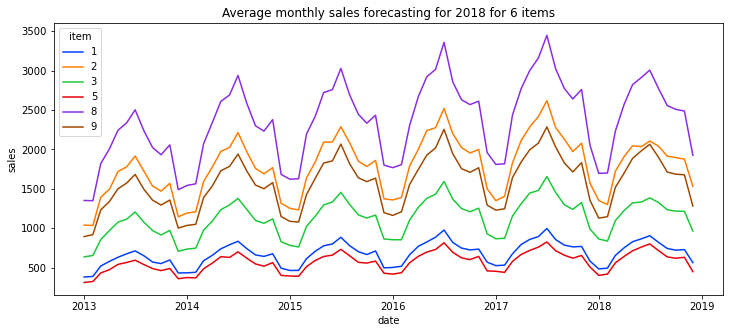

In [21]:
# Plotting the avg monthly sales prediction for 6 items
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df_sales, x="date", y="sales", hue="item",palette='bright')
plt.title('Average monthly sales forecasting for 2018 for 6 items')